In [6]:
import dask as da
import dask.dataframe as daskdf
import dask.array as daa
import dask.dataframe as dd
import dask.datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import sklearn as sk
import numpy as np
import dask_ml.preprocessing as dm_pre
import dask_ml.cluster as dm_cluster
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from scipy.stats import pearsonr
import time

In [41]:
def load_data():
    print("Loading data...")
    start = time.time()
    df = dd.read_csv("ar41_for_ulb.csv", sep=';')
    end = time.time()
    
    print("Data loaded in {} seconds".format(end - start))
    return df

ddf = load_data()
ddf = ddf.drop(columns=['X'])

# Select Data: Filtering out all data before January 2023
def select_data(df):
    print("Selecting data...")
    ddf = df[df['timestamps_UTC'] >= '2023-01-01']
    # to drop the erratic data and keep only those in 10-90 percentile for every feature
    for col in ddf.columns:
        if col not in ['timestamps_UTC', 'lat', 'lon', 'mapped_veh_id']:
            ddf = ddf[(ddf[col] > ddf[col].quantile(0)) & (ddf[col] < ddf[col].quantile(0.99))]

    return ddf

ddfprep = select_data(ddf)
#index fix 
ddfprep = ddfprep.reset_index(drop=True)
# Drop duplicates and handle missing values
ddf = ddf.drop_duplicates()
ddf = ddf.dropna()
ddf = ddf.fillna(0)

# Assuming ddfprep is your Dask DataFrame
ddfprep['timestamps_UTC'] = dd.to_datetime(ddfprep['timestamps_UTC'], errors='coerce')
ddfprep = ddfprep.sort_values('timestamps_UTC')

def per_group(df):
    print("Processing group...")
    # Rééchantillonner les données avec une moyenne sur des intervalles de 30 secondes
    resampled_df = df.set_index('timestamps_UTC').resample('30s').agg({
        'mapped_veh_id': 'first',  # Include the vehicle ID column
        'lat': 'mean',
        'lon': 'mean',
        'RS_E_RPM_PC1': 'mean',
        'RS_E_RPM_PC2': 'mean',
        'RS_E_InAirTemp_PC1': 'mean',
        'RS_E_InAirTemp_PC2': 'mean',
        'RS_E_OilPress_PC1': 'mean',
        'RS_E_OilPress_PC2': 'mean',
        'RS_E_WatTemp_PC1': 'mean',
        'RS_E_WatTemp_PC2': 'mean',
        'RS_T_OilTemp_PC1': 'mean',
        'RS_T_OilTemp_PC2': 'mean'        
    })
    # Supprimer les lignes contenant des NaN
    resampled_df = resampled_df.dropna()
    
    return resampled_df

# Appliquer la fonction à chaque groupe dans Dask DataFrame
print("Applying function to each group...")
result_df = ddfprep.groupby("mapped_veh_id").apply(per_group).compute()

print(result_df.head())  # Print the head of the resulting DataFrame


Loading data...
Data loaded in 0.005998373031616211 seconds
Selecting data...
Applying function to each group...
Processing group...


C:\Users\obave\AppData\Local\Temp\ipykernel_27408\2795931715.py:61: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  result_df = ddfprep.groupby("mapped_veh_id").apply(per_group).compute()


Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...Processing group...

Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...Processing group...

Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...
Processing group...


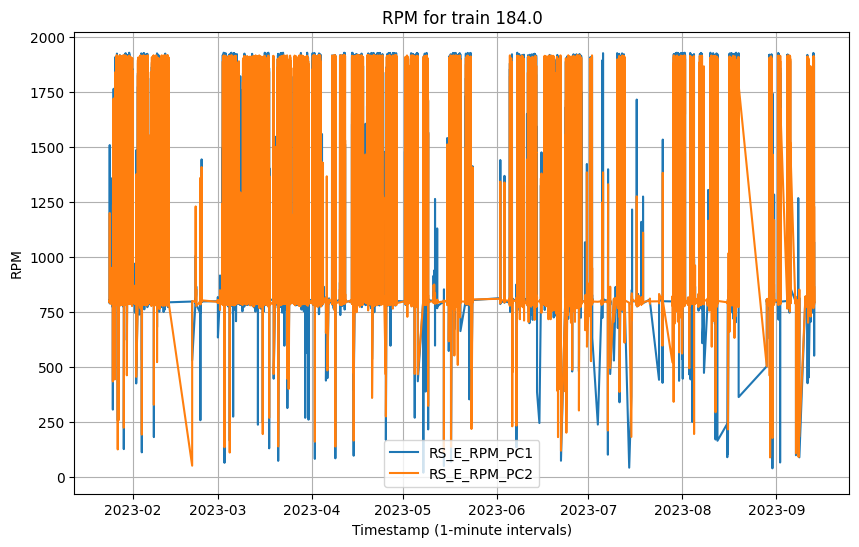

In [42]:
# Select data for vehicle 190.0 from result_df
vehicle_190_df = result_df[result_df['mapped_veh_id'] == 190.0]

# Plot RPM for vehicle 190.0
plt.figure(figsize=(10, 6))
plt.plot(vehicle_190_df.index.get_level_values('timestamps_UTC'), vehicle_190_df['RS_E_RPM_PC1'], label='RS_E_RPM_PC1')
plt.plot(vehicle_190_df.index.get_level_values('timestamps_UTC'), vehicle_190_df['RS_E_RPM_PC2'], label='RS_E_RPM_PC2')

# Customize the plot
plt.title('RPM for train 184.0')
plt.xlabel('Timestamp (1-minute intervals)')
plt.ylabel('RPM')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/160
826/826 [==============================] - 2s 2ms/step - loss: 0.0176 - val_loss: 1.1969e-05
Epoch 2/160
826/826 [==============================] - 1s 2ms/step - loss: 1.7596e-05 - val_loss: 1.1330e-05
Epoch 3/160
826/826 [==============================] - 1s 2ms/step - loss: 1.7383e-05 - val_loss: 2.4852e-05
Epoch 4/160
826/826 [==============================] - 2s 2ms/step - loss: 1.7238e-05 - val_loss: 1.7621e-05
Epoch 5/160
826/826 [==============================] - 1s 2ms/step - loss: 1.6814e-05 - val_loss: 1.3353e-05
Epoch 6/160
826/826 [==============================] - 1s 2ms/step - loss: 1.6465e-05 - val_loss: 2.1324e-05
Epoch 7/160
826/826 [==============================] - 1s 2ms/step - loss: 1.6380e-05 - val_loss: 2.0058e-05
Epoch 8/160
826/826 [==============================] - 1s 2ms/step - loss: 1.6216e-05 - val_loss: 4.2222e-06
Epoch 9/160
826/826 [==============================] - 1s 2ms/step - loss: 1.5999e-05 - val_loss: 1.0560e-05
Epoch 10/160
826/826 [=

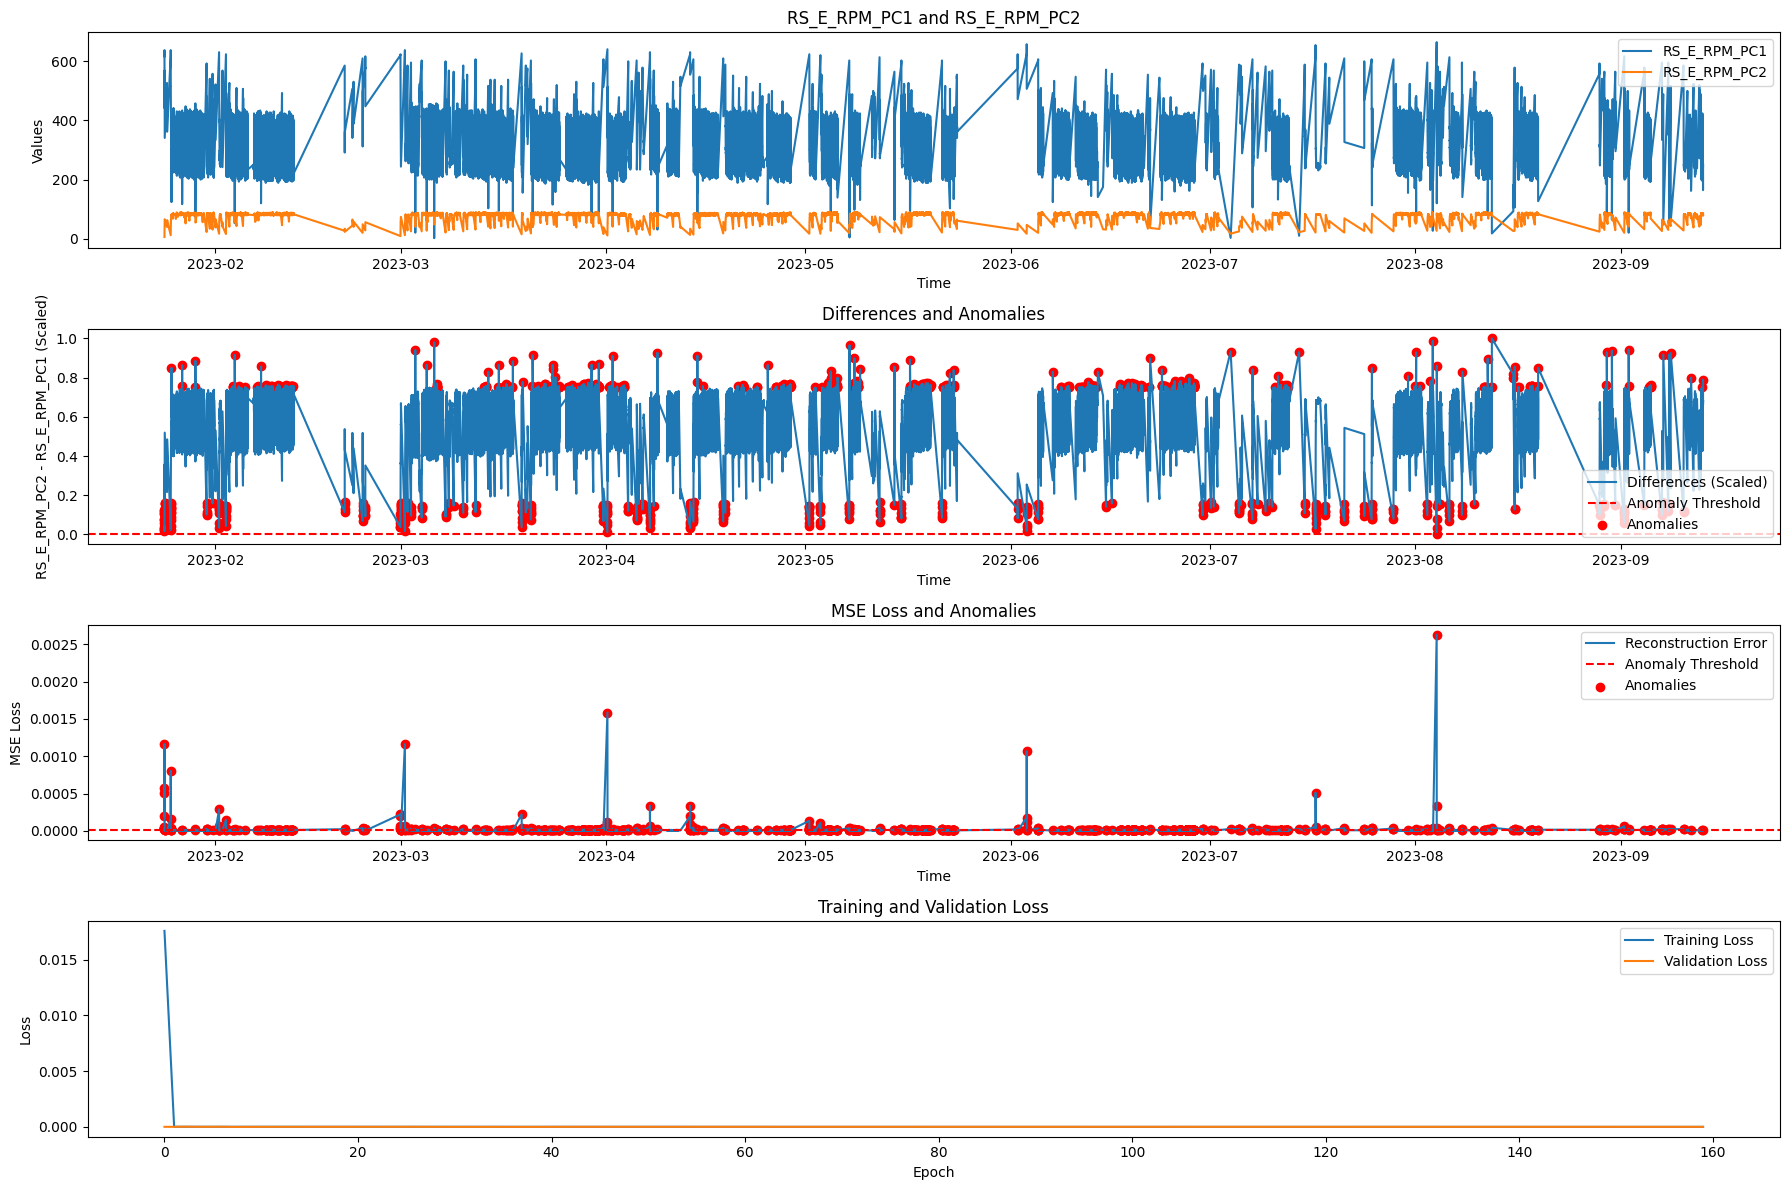

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler
# Assuming you have a DataFrame named 'vehicle_190_df' with timestamps as index
# and columns including 'RS_E_RPM_PC1' and 'RS_E_RPM_PC2'

# Select the features for anomaly detection
feature_for_anomaly_1 = vehicle_190_df['RS_E_OilPress_PC1']
feature_for_anomaly_2 = vehicle_190_df['RS_E_WatTemp_PC1']

# Reshape the data for compatibility with the autoencoder model
feature_for_anomaly_1 = feature_for_anomaly_1
feature_for_anomaly_2 = feature_for_anomaly_2

# Compute differences between the two features
feature_differences = feature_for_anomaly_2 - feature_for_anomaly_1
feature_differences = feature_differences.values.reshape(-1, 1)
# Standard scaling the data
scaler =  MinMaxScaler()
feature_differences_scaled = scaler.fit_transform(feature_differences)

# Define the LSTM Autoencoder model architecture
timesteps = 1  # You might need to adjust this based on your data
features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(timesteps, features)))
model.add(Dense(features))
model.compile(optimizer='rmsprop', loss='mse')



# Train the LSTM Autoencoder model
history = model.fit(
    feature_differences_scaled, feature_differences_scaled,
    epochs=160, batch_size=128, validation_split=0.1, verbose=1
)

# Generate predictions on the scaled data
predictions_differences = model.predict(feature_differences_scaled)

# Calculate Mean Squared Error (MSE) loss for each data point
mse_differences = np.mean(np.power(feature_differences_scaled - predictions_differences, 2), axis=1)

# Set a threshold for anomaly detection based on differences
threshold_difference = np.percentile(mse_differences, 99)

# Detect anomalies
anomalies = mse_differences > threshold_difference

# ... (your previous code)

# Visualize the original data, differences, and anomalies
plt.figure(figsize=(18, 12))

# Plot RS_E_RPM_PC1 and RS_E_RPM_PC2
plt.subplot(4, 1, 1)
plt.plot(vehicle_190_df.index.get_level_values('timestamps_UTC'), feature_for_anomaly_1, label='RS_E_RPM_PC1')
plt.plot(vehicle_190_df.index.get_level_values('timestamps_UTC'), feature_for_anomaly_2, label='RS_E_RPM_PC2')
plt.legend()
plt.title('RS_E_RPM_PC1 and RS_E_RPM_PC2')
plt.xlabel('Time')
plt.ylabel('Values')

# Plot the differences
plt.subplot(4, 1, 2)
plt.plot(vehicle_190_df.index.get_level_values('timestamps_UTC'), feature_differences_scaled, label='Differences (Scaled)')
plt.axhline(y=threshold_difference, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(vehicle_190_df.index.get_level_values('timestamps_UTC')[anomalies], feature_differences_scaled[anomalies], color='red', label='Anomalies')
plt.legend()
plt.title('Differences and Anomalies')
plt.xlabel('Time')
plt.ylabel('RS_E_RPM_PC2 - RS_E_RPM_PC1 (Scaled)')

# Plot the MSE loss
plt.subplot(4, 1, 3)
plt.plot(vehicle_190_df.index.get_level_values('timestamps_UTC'), mse_differences, label='Reconstruction Error')
plt.axhline(y=threshold_difference, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(vehicle_190_df.index.get_level_values('timestamps_UTC')[anomalies], mse_differences[anomalies], color='red', label='Anomalies')
plt.legend()
plt.title('MSE Loss and Anomalies')
plt.xlabel('Time')
plt.ylabel('MSE Loss')

# Plot training and validation loss
plt.subplot(4, 1, 4)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

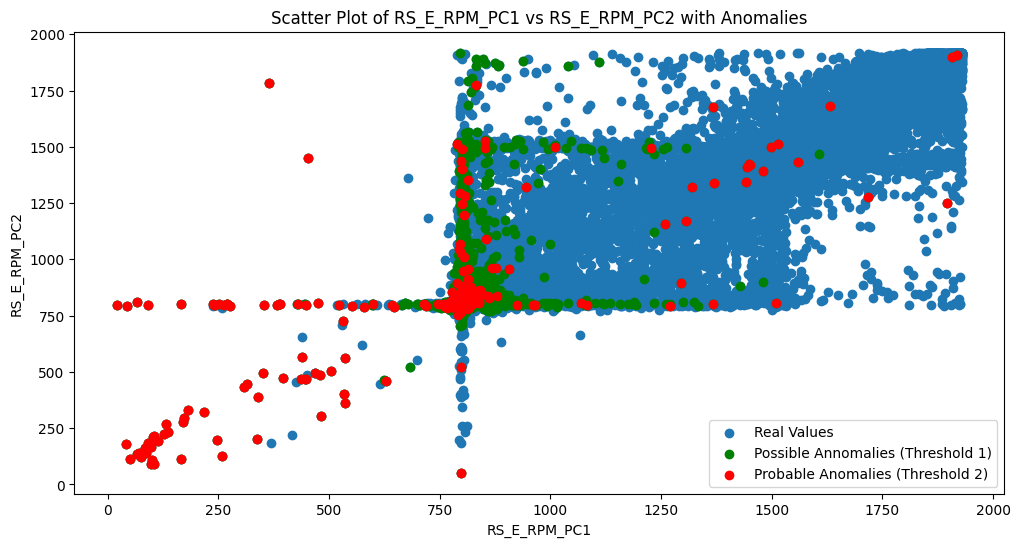

In [44]:
# Set thresholds for anomaly detection based on differences
threshold_1 = np.percentile(mse_differences, 90)
threshold_2 = np.percentile(mse_differences, 99)

# Detect anomalies
anomalies_1 = mse_differences > threshold_1
anomalies_2 = mse_differences > threshold_2

# Select the features for anomaly detection
feature_for_anomaly_1 = vehicle_190_df['RS_E_RPM_PC1']
feature_for_anomaly_2 = vehicle_190_df['RS_E_RPM_PC2']

# Reshape the data for compatibility with the autoencoder model
feature_for_anomaly_1 = feature_for_anomaly_1
feature_for_anomaly_2 = feature_for_anomaly_2

# Scatter plot of RS_E_RPM_PC1 vs RS_E_RPM_PC2
plt.figure(figsize=(12, 6))
plt.scatter(feature_for_anomaly_1, feature_for_anomaly_2, label='Real Values')
plt.scatter(feature_for_anomaly_1[anomalies_1], feature_for_anomaly_2[anomalies_1], color='green', label='Possible Annomalies (Threshold 1)')
plt.scatter(feature_for_anomaly_1[anomalies_2], feature_for_anomaly_2[anomalies_2], color='red', label='Probable Anomalies (Threshold 2)')
plt.title('Scatter Plot of RS_E_RPM_PC1 vs RS_E_RPM_PC2 with Anomalies')
plt.xlabel('RS_E_RPM_PC1')
plt.ylabel('RS_E_RPM_PC2')
plt.legend()
plt.show()

In [37]:

result = ddfprep.reset_index()
result = result.compute()
# Select data for vehicle 190.0 from result_df
vehicle_190_df = result[result['mapped_veh_id'] == 190.0]


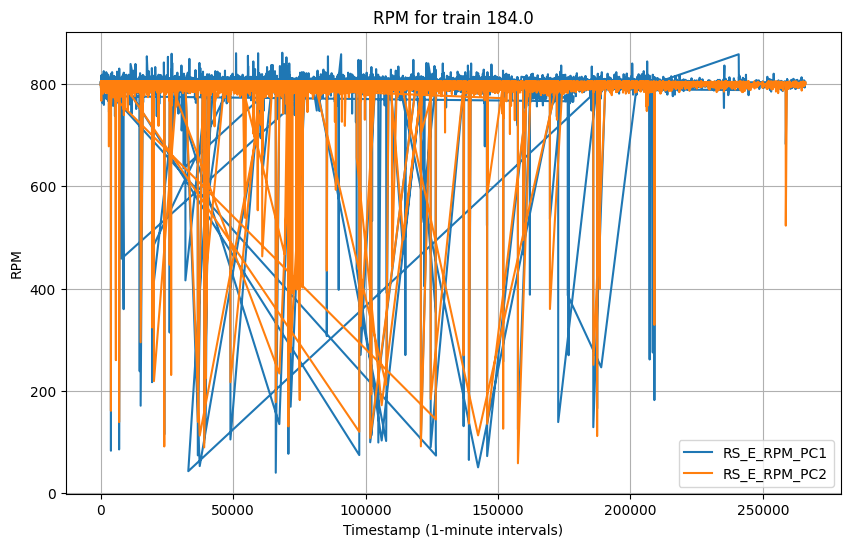

In [38]:

# Plot RPM for vehicle 190.0
plt.figure(figsize=(10, 6))
plt.plot(vehicle_190_df.index, vehicle_190_df['RS_E_RPM_PC1'], label='RS_E_RPM_PC1')
plt.plot(vehicle_190_df.index, vehicle_190_df['RS_E_RPM_PC2'], label='RS_E_RPM_PC2')

# Customize the plot
plt.title('RPM for train 184.0')
plt.xlabel('Timestamp (1-minute intervals)')
plt.ylabel('RPM')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler
# Assuming you have a DataFrame named 'vehicle_190_df' with timestamps as index
# and columns including 'RS_E_RPM_PC1' and 'RS_E_RPM_PC2'

# Select the features for anomaly detection
feature_for_anomaly_1 = vehicle_190_df['RS_E_RPM_PC1']
feature_for_anomaly_2 = vehicle_190_df['RS_E_RPM_PC2']

# Reshape the data for compatibility with the autoencoder model
feature_for_anomaly_1 = feature_for_anomaly_1
feature_for_anomaly_2 = feature_for_anomaly_2

# Compute differences between the two features
feature_differences = feature_for_anomaly_2 - feature_for_anomaly_1
feature_differences = feature_differences.values.reshape(-1, 1)
# Standard scaling the data
scaler =  MinMaxScaler()
feature_differences_scaled = scaler.fit_transform(feature_differences)

# Define the LSTM Autoencoder model architecture
timesteps = 1  # You might need to adjust this based on your data
features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(timesteps, features)))
model.add(Dense(features))
model.compile(optimizer='rmsprop', loss='mse')



# Train the LSTM Autoencoder model
history = model.fit(
    feature_differences_scaled, feature_differences_scaled,
    epochs=100, batch_size=128, validation_split=0.1, verbose=1
)

# Generate predictions on the scaled data
predictions_differences = model.predict(feature_differences_scaled)

# Calculate Mean Squared Error (MSE) loss for each data point
mse_differences = np.mean(np.power(feature_differences_scaled - predictions_differences, 2), axis=1)

# Set a threshold for anomaly detection based on differences
threshold_difference = np.percentile(mse_differences, 99)

# Detect anomalies
anomalies = mse_differences > threshold_difference

# ... (your previous code)



Epoch 1/100
826/826 [==============================] - 2s 2ms/step - loss: 0.0089 - val_loss: 1.9197e-04
Epoch 2/100
826/826 [==============================] - 1s 2ms/step - loss: 3.8716e-05 - val_loss: 2.5217e-05
Epoch 3/100
826/826 [==============================] - 1s 2ms/step - loss: 7.4154e-06 - val_loss: 6.8242e-06
Epoch 4/100
826/826 [==============================] - 1s 2ms/step - loss: 6.4527e-06 - val_loss: 8.3502e-06
Epoch 5/100
826/826 [==============================] - 1s 2ms/step - loss: 6.4017e-06 - val_loss: 5.3575e-06
Epoch 6/100
826/826 [==============================] - 2s 2ms/step - loss: 6.3827e-06 - val_loss: 1.0509e-05
Epoch 7/100
826/826 [==============================] - 1s 2ms/step - loss: 6.3358e-06 - val_loss: 9.3409e-06
Epoch 8/100
826/826 [==============================] - 1s 2ms/step - loss: 6.3467e-06 - val_loss: 2.7427e-06
Epoch 9/100
826/826 [==============================] - 2s 2ms/step - loss: 6.2924e-06 - val_loss: 9.7862e-06
Epoch 10/100
826/826 [=

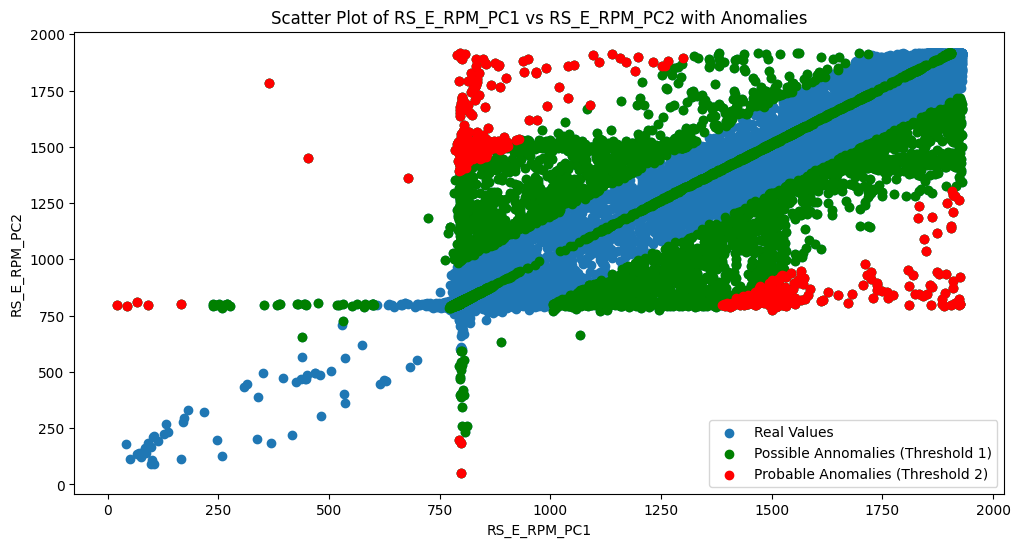

In [47]:
# Set thresholds for anomaly detection based on differences
threshold_1 = np.percentile(mse_differences, 90)
threshold_2 = np.percentile(mse_differences, 99.5)

# Detect anomalies
anomalies_1 = mse_differences > threshold_1
anomalies_2 = mse_differences > threshold_2

# Select the features for anomaly detection
feature_for_anomaly_1 = vehicle_190_df['RS_E_RPM_PC1']
feature_for_anomaly_2 = vehicle_190_df['RS_E_RPM_PC2']

# Reshape the data for compatibility with the autoencoder model
feature_for_anomaly_1 = feature_for_anomaly_1
feature_for_anomaly_2 = feature_for_anomaly_2

# Scatter plot of RS_E_RPM_PC1 vs RS_E_RPM_PC2
plt.figure(figsize=(12, 6))
plt.scatter(feature_for_anomaly_1, feature_for_anomaly_2, label='Real Values')
plt.scatter(feature_for_anomaly_1[anomalies_1], feature_for_anomaly_2[anomalies_1], color='green', label='Possible Annomalies (Threshold 1)')
plt.scatter(feature_for_anomaly_1[anomalies_2], feature_for_anomaly_2[anomalies_2], color='red', label='Probable Anomalies (Threshold 2)')
plt.title('Scatter Plot of RS_E_RPM_PC1 vs RS_E_RPM_PC2 with Anomalies')
plt.xlabel('RS_E_RPM_PC1')
plt.ylabel('RS_E_RPM_PC2')
plt.legend()
plt.show()